# Perform whole-brain image decoding
Decode whole-brain images from [Rubin et al. (2016)](http://www.biorxiv.org/content/early/2016/06/18/059618).

In [1]:
%matplotlib inline
import urllib
from os import mkdir
from os.path import isdir, join
from shutil import move, rmtree

import nibabel as nib
from pyneurovault import api
from nilearn import plotting
from neurosynth.tests.utils import get_resource_path

from gclda.model import Model
from gclda.decode import Decoder
from gclda import utils

/Users/tsalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Download images

In [2]:
out_dir = 'temp/'
if isdir(out_dir):
    rmtree(out_dir)
mkdir(out_dir)

### From Neurovault (4/6)

In [3]:
nv_images = {'012604': 'yeo_2014_cognitive_component_5',
             '012608': 'yeo_2014_cognitive_component_9',
             '003142': 'hcp_language_task_language-math',
             '003128': 'hcp_emotion_task_faces-shapes'}
image_nums = [int(k) for k in nv_images.keys()]

images_df = api.get_images(pks=image_nums)
standard = join(get_resource_path(), 'MNI152_T1_2mm_brain.nii.gz')
api.download_images(dest_dir=out_dir, images_df=images_df, target=standard)

for k, v in nv_images.iteritems():
    move(join(out_dir, 'resampled/{0}.nii.gz'.format(k)),
         join(out_dir, 'resampled/{0}.nii.gz'.format(v)))

Extracting NeuroVault images meta data...
Retrieving image 3142...
http://neurovault.org/api/images/3142/?format=json
Retrieving image 3128...
http://neurovault.org/api/images/3128/?format=json
Retrieving image 12608...
http://neurovault.org/api/images/12608/?format=json
Retrieving image 12604...
http://neurovault.org/api/images/12604/?format=json
Extrapolating temp/original/3142.nii.gz


/Users/tsalo/anaconda/lib/python2.7/site-packages/nilearn-0.3.1-py2.7.egg/nilearn/masking.py:95: RuntimeWarning: invalid value encountered in divide
  / np.sum(np.isfinite(extrapolation), axis=0))


Resampling temp/original/3142.nii.gz
Extrapolating temp/original/3128.nii.gz
Resampling temp/original/3128.nii.gz
Extrapolating temp/original/12608.nii.gz
Resampling temp/original/12608.nii.gz
Extrapolating temp/original/12604.nii.gz
Resampling temp/original/12604.nii.gz


### From FMRIB (2/6)

In [4]:
fmrib_images = {9: 'smith_2009_ica_component_10',
                12: 'smith_2009_ica_component_13'}

url = 'http://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/bm20.nii.gz'
rsn_file = join(out_dir, 'resampled/bm20.nii.gz')
urllib.urlretrieve(url, rsn_file)

hed = nib.load(rsn_file)
data = hed.get_data()
for k, v in fmrib_images.iteritems():
    f = join(out_dir, 'resampled/{0}.nii.gz'.format(v))
    arr = data[:, :, :, k]
    img = nib.Nifti1Image(arr, hed.affine)
    img.to_filename(f)

In [5]:
#raise Exception()

In [6]:
#hed = nib.load(rsn_file)
#data = hed.get_data()
#for i in range(data.shape[-1]):
#    f = join(out_dir, 'resampled/smith_{0}.nii.gz'.format(i))
#    arr = data[:, :, :, i]
#    img = nib.Nifti1Image(arr, hed.affine)
#    img.to_filename(f)

In [7]:
#file_to_decode = join(out_dir, 'resampled/smith_2009_ica_component_13.nii.gz')
#img_to_decode = nib.load(file_to_decode)

#for i in range(data.shape[-1]):
#    f = join(out_dir, 'resampled/smith_{0}.nii.gz'.format(i))
#    img = nib.load(f)
#    fig = plotting.plot_stat_map(img, display_mode='z', 
#                                 threshold=1.5,
#                                 cut_coords=[-10, 8, 26, 62])

## Decode images

In [8]:
# Load example model and initialize decoder
model = Model.load(join(utils.get_resource_path(), 'models',
                        'Neurosynth2015Filtered2',
                        'model_200topics_2015Filtered2.pkl'))
decoder = Decoder(model)

model.display_model_summary()

--- Model Summary ---
 Current State:
	 Current Iteration   = 1000
	 Initialization Seed = 1
	 Current Log-Likely  = -10981413.4523
 Model Hyper-Parameters:
	 Symmetric = 0.1
	 n_topics  = 200
	 n_regions = 2
	 alpha     = 0.010
	 beta      = 0.010
	 gamma     = 1.000
	 delta     = 25.000
	 roi_size  = 1.000
	 dobs      = 50
 Model Training-Data Information:
	 Dataset Label                 = 2015Filtered2
	 Word-Tokens (n_word_tokens)   = 520492
	 Peak-Tokens (n_peak_tokens)   = 400801
	 Word-Types (n_word_labels)    = 6755
	 Documents (n_docs)            = 11362
	 Peak-Dimensions (n_peak_dims) = 3


### Yeo et al. (2014): cognitive component 5
From the 12-component solution.

             Weight
Term               
visual     0.014993
motor      0.008143
words      0.007444
face       0.005826
social     0.005083
attention  0.004897
language   0.004760
memory     0.004740
learning   0.004649
word       0.004633


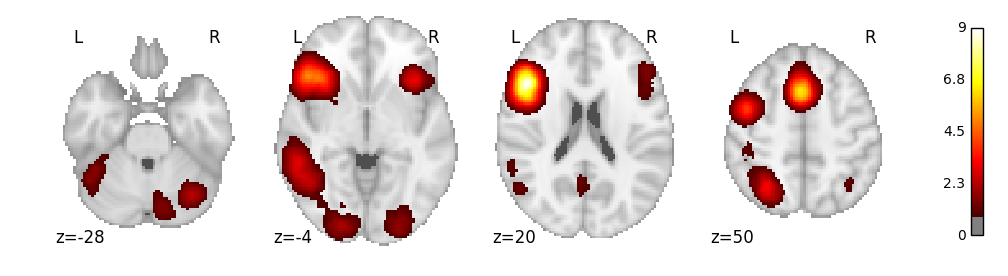

In [9]:
file_to_decode = join(out_dir, 'resampled/yeo_2014_cognitive_component_5.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=.9,
                             cut_coords=[-28, -4, 20, 50])

print(df.head(10))

### Yeo et al. (2014): cognitive component 9
From the 12-component solution.

                  Weight
Term                    
attention       0.011707
visual          0.009028
working_memory  0.008799
attentional     0.005918
learning        0.005916
motor           0.005595
spatial         0.005113
social          0.004502
number          0.004245
monitoring      0.003875


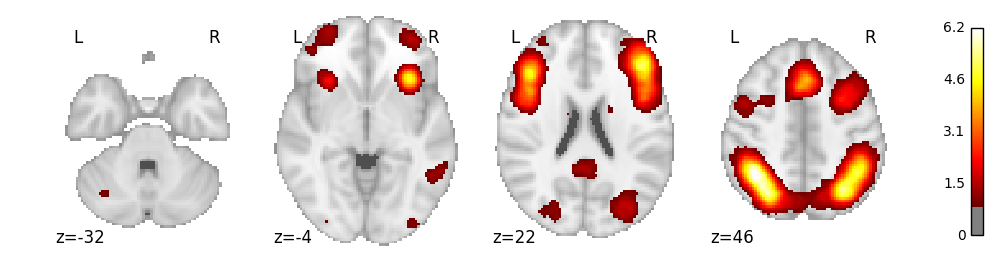

In [10]:
file_to_decode = join(out_dir, 'resampled/yeo_2014_cognitive_component_9.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=.9,
                             cut_coords=[-32, -4, 22, 46])

print(df.head(10))

### Smith et al. (2009): ICA component 10

            Weight
Term              
social    0.012373
learning  0.009559
wm        0.009108
training  0.006926
pd        0.006246
conflict  0.005270
adhd      0.005233
pain      0.004880
load      0.004845
self      0.004760


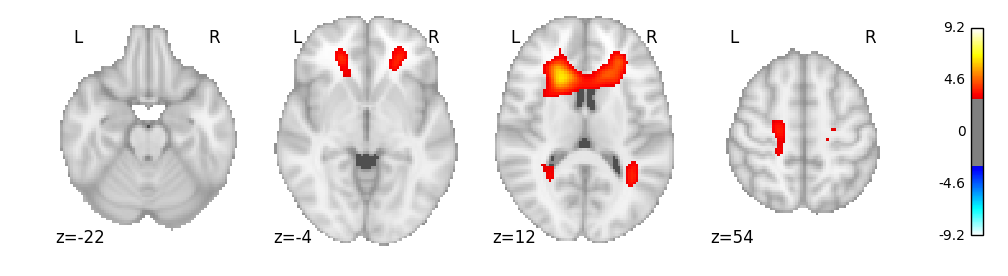

In [11]:
file_to_decode = join(out_dir, 'resampled/smith_2009_ica_component_10.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=3,
                             cut_coords=[-22, -4, 12, 54])

print(df.head(10))

### Smith et al. (2009): ICA component 13

                     Weight
Term                       
stimulation        0.011069
auditory           0.009316
social             0.009151
somatosensory      0.008523
attention          0.008421
language           0.007530
working_memory     0.006990
sensory            0.006849
cognitive_control  0.005995
intensity          0.005535


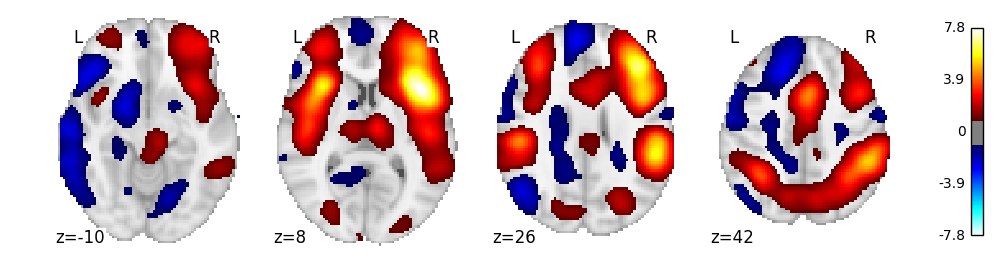

In [12]:
file_to_decode = join(out_dir, 'resampled/smith_2009_ica_component_13.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=.9,
                             cut_coords=[-10, 8, 26, 42])

print(df.head(10))

### HCP language task: language > math

                  Weight
Term                    
motor           0.021264
visual          0.016830
attention       0.012324
spatial         0.010740
working_memory  0.009168
learning        0.008038
verbal          0.006781
target          0.006686
monitoring      0.005871
attentional     0.005217


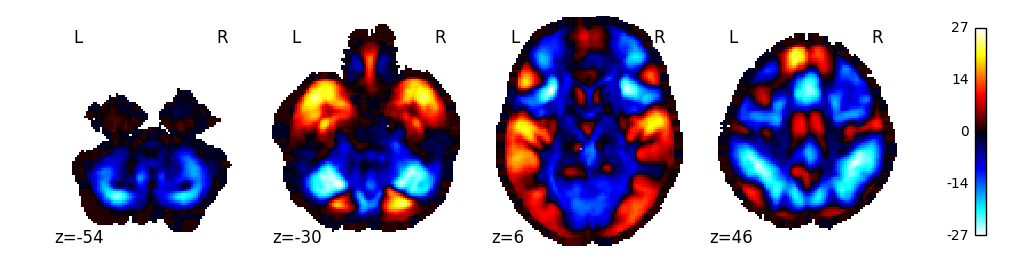

In [13]:
file_to_decode = join(out_dir, 'resampled/hcp_language_task_language-math.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=.001, black_bg=False,
                             cut_coords=[-54, -30, 6, 46])

print(df.head(10))

### HCP emotion task: faces > shapes

              Weight
Term                
visual      0.044085
face        0.016365
emotional   0.014067
memory      0.012765
faces       0.011606
encoding    0.008838
words       0.007542
pictures    0.006635
emotion     0.005971
perceptual  0.005717


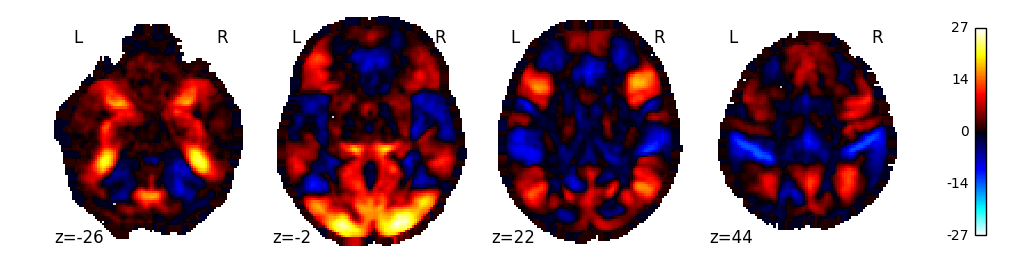

In [14]:
file_to_decode = join(out_dir, 'resampled/hcp_emotion_task_faces-shapes.nii.gz')
img_to_decode = nib.load(file_to_decode)

df = decoder.decode_continuous(file_to_decode)
df = df.sort_values(by='Weight', ascending=False)

fig = plotting.plot_stat_map(img_to_decode, display_mode='z', 
                             threshold=.001, black_bg=False,
                             cut_coords=[-26, -2, 22, 44])

print(df.head(10))

## Perform cleanup

In [15]:
if isdir(out_dir):
    rmtree(out_dir)